<font size="12">Organ_detecter</font>

# Setting up

## Importing libraries

In [1]:
import pandas as pd
import pathlib
import keras
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as preprocess_input_vgg16
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input as preprocess_input_vgg19
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input as preprocess_input_restnet
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPool2D



## Importing data

In [12]:
lung_diseases = ['Airspace_opacity','Bronchiectasis','interstitial_lung_disease','Nodule','normal','Parenchyma_destruction']
brain_diseases = ['acute_infarct','chronic_infarct','extra','focal_flair_hyper','intra','normal','white_matter_changes']
knee_diseases = ['acl_pathology','bone_inflammation','chondral_abnormality',
    'fracture','intra','meniscal_abnormality','normal','patella_pathology','pcl_pathology','soft_tissue_fluid_collection']
shoulder_diseases = ['acj_oa','biceps_pathology','ghj_oa','labral_pathology','marrow_inflammation','normal',
                     'osseous_lesion','post_op','soft_tissue_edema','soft_tissue_fluid','supraspinatus_pathology']
spine_diseases = ['cord_pathology','cystic_lesions','disc_pathology','normal','osseous_abn']


In [13]:
url_lung = [f'../Data/CT/Lung/{i}/' for i in lung_diseases]
url_brain= [f'../Data/MR/brain/{i}/' for i in brain_diseases]
url_knee = [f'../Data/MR/knee/{i}/' for i in knee_diseases]
url_shoulder = [f'../Data/MR/shoulder/{i}/' for i in shoulder_diseases]
url_spine= [f'../Data/MR/spine/{i}/' for i in spine_diseases]


In [14]:
limit = 100

In [16]:
images_lung = [cv2.imread(file) for path in url_lung for file in glob.glob(path + "*.png")[:limit]]
images_brain = [cv2.imread(file) for path in url_brain for file in glob.glob(path + "*.png")[:limit]]
images_knee = [cv2.imread(file) for path in url_knee for file in glob.glob(path + "*.png")[:limit]]
images_shoulder = [cv2.imread(file) for path in url_shoulder for file in glob.glob(path + "*.png")[:limit]]
images_spine = [cv2.imread(file) for path in url_spine for file in glob.glob(path + "*.png")[:limit]]

In [18]:
labels_lung = [0] * len(images_lung)
labels_brain = [1] * len(images_brain)
labels_knee = [2] * len(images_knee)
labels_shoulder = [3] * len(images_shoulder)
labels_spine= [4] * len(images_spine)

## Checking data

In [7]:
lung_count = len(images_lung)
lung_count

600

In [8]:
brain_count = len(images_brain)
brain_count

700

In [9]:
knee_count = len(images_knee)
knee_count

1000

In [17]:
shoulder_count = len(images_shoulder)
shoulder_count

1100

In [11]:
spine_count = len(images_spine)
spine_count

500

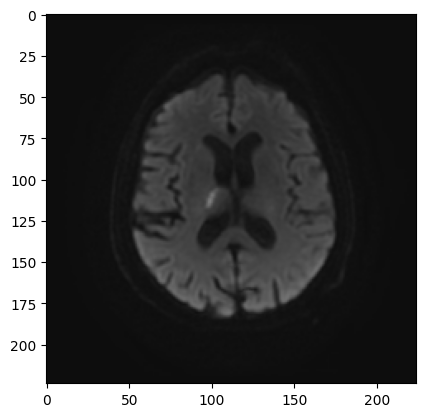

In [19]:
img = np.asarray(images_brain[0])
imgplot = plt.imshow(img)

# Model definition

##  VGG16

In [20]:
def initialize_vgg16_model():
    # Load the pre-trained VGG16 model without the top (fully connected) layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of the pre-trained VGG16 model
    for layer in base_model.layers:
        layer.trainable = False

    # Create a Sequential model
    model = Sequential()

    # Add the pre-trained VGG16 model as the first layer
    model.add(base_model)

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(5, activation='softmax'))

    # Model compilation
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

# Creating X and y for training and testing

In [21]:
X = np.concatenate((images_lung, images_brain, images_knee, images_shoulder, images_spine), axis=0)
y = np.concatenate((labels_lung, labels_brain, labels_knee, labels_shoulder, labels_spine), axis=0)

In [22]:
X.shape

(3900, 224, 224, 3)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [24]:
X_train = preprocess_input_vgg16(X_train) 
X_test = preprocess_input_vgg16(X_test)

In [25]:
X_train.shape

(3120, 224, 224, 3)

In [26]:
y_train.shape

(3120,)

# Training the model

In [27]:
model = initialize_vgg16_model()

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 100)               2508900   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 505       
                                                                 
Total params: 17224093 (65.70 MB)
Trainable params: 2509405 (9.57 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [29]:
es = EarlyStopping(patience = 5, restore_best_weights=True)

history = model.fit(X_train, y_train, 
          epochs=50,
          batch_size=32,
          validation_split = 0.2,
          callbacks=[es],
          verbose=1)




Epoch 1/50
78/78 [==============================] - 210s 3s/step - loss: 0.8407 - accuracy: 0.9683 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/50
78/78 [==============================] - 335s 4s/step - loss: 0.0445 - accuracy: 0.9956 - val_loss: 1.9104e-10 - val_accuracy: 1.0000
Epoch 3/50
78/78 [==============================] - 331s 4s/step - loss: 0.0124 - accuracy: 0.9992 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/50
78/78 [==============================] - 262s 3s/step - loss: 7.8540e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/50
78/78 [==============================] - 215s 3s/step - loss: 0.0167 - accuracy: 0.9988 - val_loss: 0.0143 - val_accuracy: 0.9984
Epoch 6/50
78/78 [==============================] - 213s 3s/step - loss: 0.1350 - accuracy: 0.9956 - val_loss: 0.0110 - val_accuracy: 0.9984


# Testing the model and displaying results

In [30]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

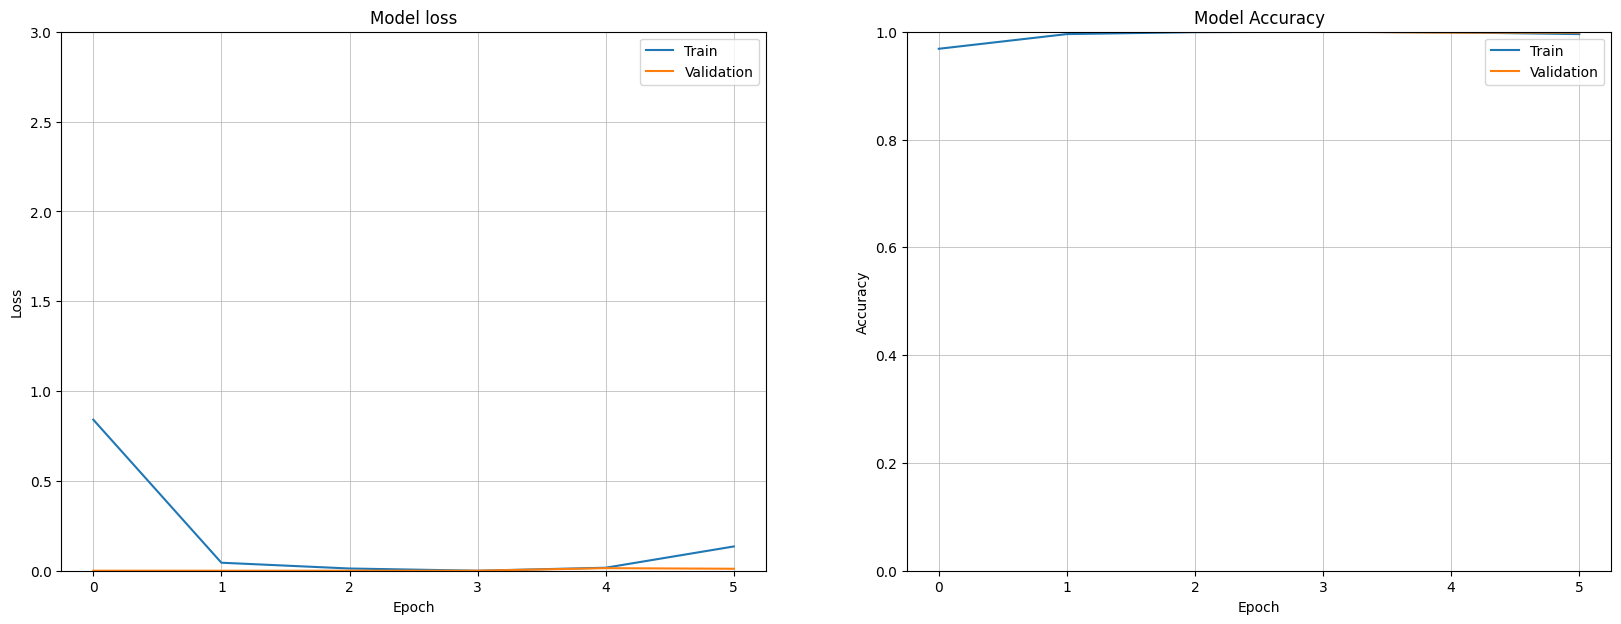

In [31]:
plot_loss_accuracy(history, title=None)

In [32]:
evaluation = model.evaluate(X_test, y_test)

25/25 [==============================] - 52s 2s/step - loss: 8.9734e-05 - accuracy: 1.0000


In [33]:
print(f'Model accuracy is {round(evaluation[1]*100,2)} %')

Model accuracy is 100.0 %


In [34]:
y_pred = model.predict(X_test)


25/25 [==============================] - 52s 2s/step


In [35]:
results = pd.DataFrame(y_pred)
results['reels'] = y_test

In [36]:
results

,0,1,2,3,4,reels
0,0.0,1.0,0.0,0.0,0.0,1
1,1.0,0.0,0.0,0.0,0.0,0
2,0.0,1.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,1.0,0.0,3
4,0.0,0.0,0.0,1.0,0.0,3
...,...,...,...,...,...,...
775,0.0,0.0,1.0,0.0,0.0,2
776,0.0,0.0,1.0,0.0,0.0,2
777,0.0,0.0,0.0,1.0,0.0,3
778,0.0,0.0,1.0,0.0,0.0,2
